In [1]:
import sys
import os

import xml.etree.ElementTree as ET
from treelib import Node, Tree

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [2]:
from bowtie.dataresources.opsa import OPSA_Container, OPSA_Gate, OPSA_Basic_Event, OPSA_Path, OPSA_Functional_Event
from bowtie.dataresources.type_definitions import EventType, GateType
from bowtie.io.import_opsa import OPSA_Importer

from bowtie.mapping.mapping_bowtie import MappingBowTie

# Import a bow tie

In [3]:
# define opsa file
filename = '../data/test_et_v03_works.xml'
filename = '../data/test_et_v03_true.xml'
filename = '../data/khakzad_dynamic_v03.xml'
#filename = '../data/Zarei_regulator_system_v01.xml'

In [4]:
# read file
xml_root = ET.parse(filename).getroot()
tree = Tree()
tree_root = tree.create_node('root')
importer = OPSA_Importer()
importer.parse(xml_root, tree, tree_root)

In [5]:
# show imported data
tree.show()

root
├── Heat-Exchanger_Accident-Scenario
│   └── Vapor
│       ├── HTPC
│       │   ├── ATCS
│       │   │   ├── A-valve
│       │   │   └── T-ctrl-sys
│       │   │       ├── P-unit
│       │   │       └── Sensors
│       │   └── MTCS
│       │       ├── M-valve
│       │       └── T-sys
│       │           ├── Operator
│       │           └── Thermo
│       └── Vent-sys
│           ├── Belt
│           ├── Duct
│           ├── Fan
│           └── Vent
└── Vapor
    └── EventTree
        └── Ignition
            ├── Path.Ignition.fails
            │   └── Sprinkler
            │       ├── Path.Sprinkler.fails
            │       │   └── Alarm
            │       │       ├── Path.Alarm.fails
            │       │       │   └── C8
            │       │       └── Path.Alarm.works
            │       │           └── C7
            │       └── Path.Sprinkler.works
            │           └── Alarm
            │               ├── Path.Alarm.fails
            │               │   └── C6
    

# Map data

In [6]:
mapper = MappingBowTie(tree)
model = mapper.map()

mapping from Bow-Tie to Bayesian network


In [7]:
model.check_model()

True

In [8]:
# show model nodes
print('nodes', len(model.nodes()))
print(model.nodes())

nodes 21
['Fan', 'Duct', 'Vent', 'Belt', 'A-valve', 'Sensors', 'P-unit', 'M-valve', 'Operator', 'Thermo', 'Vapor', 'HTPC', 'Vent-sys', 'ATCS', 'MTCS', 'T-ctrl-sys', 'T-sys', 'Ignition', 'Consequence', 'Sprinkler', 'Alarm']


/Users/frankz/.local/share/virtualenvs/masterarbeit-CH-u_RrC/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


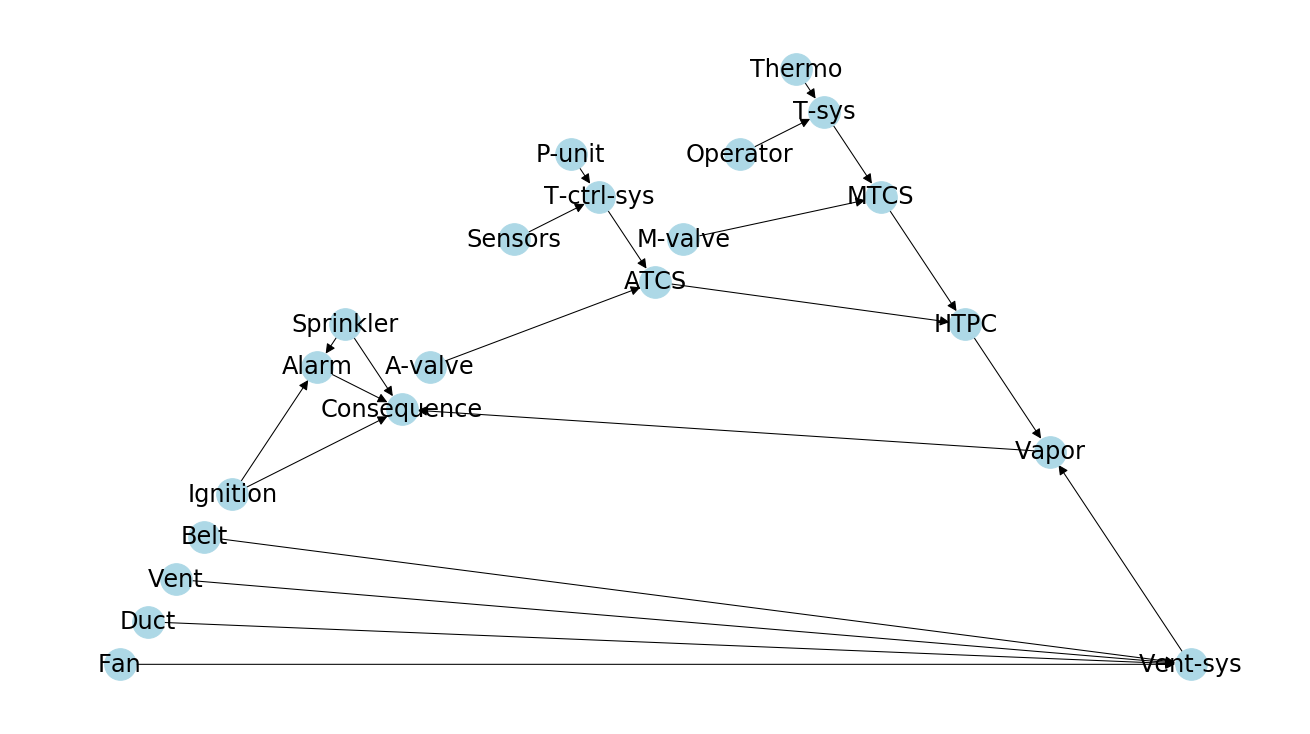

In [9]:
import networkx as nx
#import pylab as plt

import matplotlib.pyplot as plt

options = {
    'with_labels': True,
    'arrowsize': 20,
    'node_color': 'lightblue',
    'node_size': 1000,
    'font_size': 24,
    'line_widths': 2.0,
    'width': 1.05,
    'node_shape': 'o',
}
plt.figure(3,figsize=(18,10)) 

nx.draw_planar(model, **options)
# plt.savefig('bar.png')
plt.show()

In [14]:
# print CPD tables of bayesian network:
for cpd in model.cpds:
    print(cpd)

+------------+------+
| Fan(works) | 0.99 |
+------------+------+
| Fan(fails) | 0.01 |
+------------+------+
+-------------+-------+
| Duct(works) | 0.999 |
+-------------+-------+
| Duct(fails) | 0.001 |
+-------------+-------+
+-------------+-------+
| Vent(works) | 0.985 |
+-------------+-------+
| Vent(fails) | 0.015 |
+-------------+-------+
+-------------+------+
| Belt(works) | 0.95 |
+-------------+------+
| Belt(fails) | 0.05 |
+-------------+------+
+----------------+--------+
| A-valve(works) | 0.9724 |
+----------------+--------+
| A-valve(fails) | 0.0276 |
+----------------+--------+
+----------------+------+
| Sensors(works) | 0.96 |
+----------------+------+
| Sensors(fails) | 0.04 |
+----------------+------+
+---------------+--------+
| P-unit(works) | 0.7985 |
+---------------+--------+
| P-unit(fails) | 0.2015 |
+---------------+--------+
+----------------+--------+
| M-valve(works) | 0.9757 |
+----------------+--------+
| M-valve(fails) | 0.0243 |
+----------------+

# Inference of bayesian network

## Top Event

In [15]:
node_te = mapper.get_top_event(tree)
print('top event = {}'.format(node_te.tag))

top event = Vapor


In [16]:
infer = VariableElimination(model)
te_dist = infer.query(variables=[node_te.tag])
print(te_dist)

Eliminating: ATCS: 100%|██████████| 20/20 [00:00<00:00, 421.59it/s]

+--------------+--------------+
| Vapor        |   phi(Vapor) |
+==============+==============+
| Vapor(works) |       0.9983 |
+--------------+--------------+
| Vapor(fails) |       0.0017 |
+--------------+--------------+


## Consequence

In [17]:
# Consequences
consequence = mapper.consequence_name
#print(consequence)
c_dist = infer.query(variables=[consequence])
print(c_dist)

Eliminating: ATCS: 100%|██████████| 20/20 [00:00<00:00, 207.85it/s]

+-------------------+--------------------+
| Consequence       |   phi(Consequence) |
+===================+====================+
| Consequence(C3)   |             0.0000 |
+-------------------+--------------------+
| Consequence(C5)   |             0.0000 |
+-------------------+--------------------+
| Consequence(C6)   |             0.0002 |
+-------------------+--------------------+
| Consequence(C8)   |             0.0000 |
+-------------------+--------------------+
| Consequence(C1)   |             0.0003 |
+-------------------+--------------------+
| Consequence(C7)   |             0.0000 |
+-------------------+--------------------+
| Consequence(Safe) |             0.9983 |
+-------------------+--------------------+
| Consequence(C4)   |             0.0000 |
+-------------------+--------------------+
| Consequence(C2)   |             0.0011 |
+-------------------+--------------------+


In [18]:
print(c_dist.values)

[1.36127853e-05 2.09737729e-07 1.61126977e-04 6.71362402e-06
 3.26706846e-04 8.73907202e-09 9.98319409e-01 4.68884826e-05
 1.12532358e-03]


## Probabilities of failure

In [19]:
# get probability
ie1_dist = infer.query(variables=["IE1"])
ie2_dist = infer.query(variables=["IE5"])
ie3_dist = infer.query(variables=["IE9"])
print(ie1_dist)
print(ie2_dist)
print(ie3_dist)

Eliminating: Duct: 100%|██████████| 21/21 [00:00<00:00, 346.32it/s]


NotImplementedError: All the args are expected to be instances of the same factor class.

In [ ]:
human_failure = "IE1"
h_dist = infer.query(variables=["IE1"], evidence={'RSF': "works"})
print(h_dist)

In [ ]:
# find the probability of human failure if the RSF fails
h_dist = infer.query(variables=["IE1"], evidence={'RSF': "fails"})
print(h_dist)

In [ ]:
# find the probability of process failure if the RSF fails
h_dist = infer.query(variables=["IE5"], evidence={'RSF': "fails"})
print(h_dist)

In [ ]:
# find the probability of mechanical failure if the RSF fails
h_dist = infer.query(variables=["IE9"], evidence={'RSF': "fails"})
print(h_dist)

In [ ]:
# find the probability of human, process, and mechanical failure if the RSF fails
h_dist = infer.query(variables=["IE1", "IE5", "IE9"], evidence={'RSF': "fails"})
print(h_dist)